In [1]:
%load_ext autoreload
%autoreload 2

# Recommender Systems 2023/24

### Practice 3 - Collaborative Based recommenders


### Load the data you saw last time:

In [2]:
import numpy as np
import matplotlib.pyplot as pyplot

%matplotlib inline

Let's use the DataReader provided with the course repo

In [3]:
# from Data_manager.Movielens.Movielens10MReader import Movielens10MReader
from Data_manager.competition import CompetitionReader
from Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import (
    split_train_in_two_percentage_global_sample,
)

In [4]:
# dataReader = Movielens10MReader()
dataReader = CompetitionReader()
dataset = dataReader.load_data()

URM_all = dataset.get_URM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(
    URM_all, train_percentage=0.80
)
URM_train, URM_validation = split_train_in_two_percentage_global_sample(
    URM_train, train_percentage=0.80
)

evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

competition: Verifying data consistency...
competition: Verifying data consistency... Passed!
DataReader: current dataset is: competition
	Number of items: 38121
	Number of users: 35736
	Number of interactions in URM_all: 1764607
	Value range in URM_all: 1.00-1.00
	Interaction density: 1.30E-03
	Interactions per user:
		 Min: 1.20E+01
		 Avg: 4.94E+01
		 Max: 5.90E+03
	Interactions per item:
		 Min: 1.20E+01
		 Avg: 4.63E+01
		 Max: 1.47E+03
	Gini Index: 0.43

	ICM name: ICM_all, Value range: 1.00 / 1.00, Num features: 94331, feature occurrences: 2940040, density 8.18E-04


EvaluatorHoldout: Ignoring 455 ( 1.3%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 156 ( 0.4%) Users that have less than 1 test interactions


# Item-based Collaborative Filtering

#### We apply the cosine similarity again, but using the URM columns

In [5]:
item_id = 80
shrink = 10

numerator_vector = URM_train.T[item_id].dot(URM_train).toarray().ravel()
numerator_vector

array([0., 0., 0., ..., 0., 0., 0.])

In [6]:
item_norms = np.sqrt(np.array(URM_train.power(2).sum(axis=0))).ravel()
denominator_vector = item_norms[item_id] * item_norms + shrink + 1e-6

similarity_vector = numerator_vector / denominator_vector

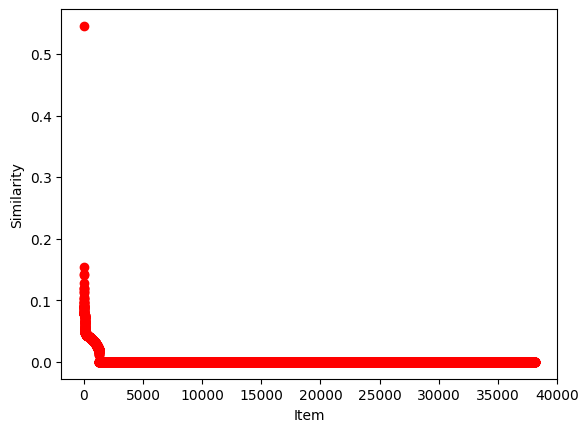

In [7]:
sorted_item_indices = np.argsort(-similarity_vector)

pyplot.plot(similarity_vector[sorted_item_indices], "ro")
pyplot.ylabel("Similarity")
pyplot.xlabel("Item")
pyplot.show()

### Let's compute the whole similarity and see the predictions for a certain item

In [8]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(
    URM_train, shrink=100, topK=50, normalize=True, similarity="cosine"
)

W_sparse = similarity_object.compute_similarity()

Similarity column 38121 (100.0%), 1544.82 column/sec. Elapsed time 24.68 sec


In [9]:
user_id = 80

user_profile = URM_train[user_id]
scores = user_profile.dot(W_sparse).toarray().ravel()

ranking = scores.argsort()[::-1]

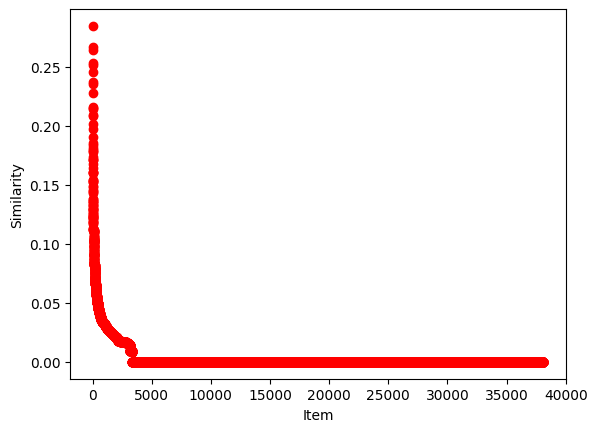

In [10]:
pyplot.plot(scores[ranking], "ro")
pyplot.ylabel("Similarity")
pyplot.xlabel("Item")
pyplot.show()

### Then compute the final recommendation list

In [11]:
ranking[0:10]

array([5596, 5590, 3869, 5653, 1243, 5620, 5110, 5645, 5622, 5356])

## Put all together in a class

In [12]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python
import numpy as np


class ItemKNNCFRecommender(object):
    def __init__(self, URM):
        self.URM = URM

    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        similarity_object = Compute_Similarity_Python(
            self.URM,
            shrink=shrink,
            topK=topK,
            normalize=normalize,
            similarity=similarity,
        )

        self.W_sparse = similarity_object.compute_similarity()

    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]

    def filter_seen(self, user_id, scores):
        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id + 1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

## Test our CF recommender:

In [13]:
recommender = ItemKNNCFRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)

Similarity column 38121 (100.0%), 1637.25 column/sec. Elapsed time 23.28 sec


#### Let's compute recommendations for a fixed group of users

In [14]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)

end_time = time.time()

print(
    "Reasonable implementation speed is {:.2f} usr/sec".format(
        n_users_to_test / (end_time - start_time)
    )
)

Reasonable implementation speed is 172.58 usr/sec


## Remember to keep the URM in CSR format!

## Hyperarameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Optimize the recommendation qualtiy on the validation data, then use those hyperparameters to train the model in all the data you have (train + validation) and evaluate on the test data

#### Number of neighbors

In [15]:
import pandas as pd
from scipy.stats import loguniform
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

hyperparameter_search_rnd = pd.DataFrame(columns=["k", "MAP"])
hyperparameter_search_rnd["k"] = loguniform.rvs(10, 1000, size=11).astype(int)
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="k")

for index in hyperparameter_search_rnd.index:
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=hyperparameter_search_rnd.loc[index, "k"])

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    hyperparameter_search_rnd.loc[index, "MAP"] = result_df.loc[10]["MAP"]

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1722.62 column/sec. Elapsed time 22.13 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 11.10 sec. Users per second: 3178
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1826.99 column/sec. Elapsed time 20.87 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 11.16 sec. Users per second: 3161
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1725.11 column/sec. Elapsed time 22.10 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 11.34 sec. Users per second: 3111
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1683.65 column/sec. Elapsed time 22.64 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 12.64 sec. Users per second: 2791
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1713.55 column/sec. Elapsed 

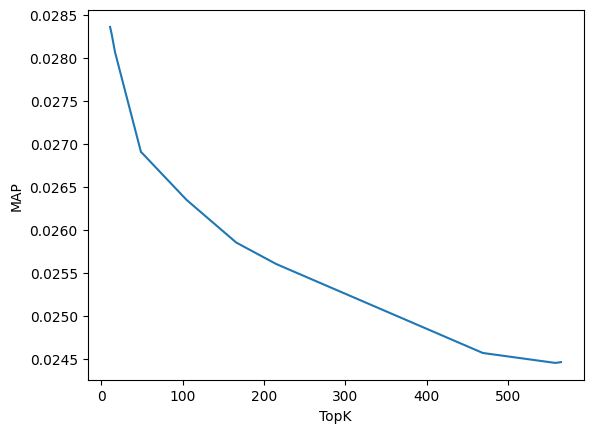

In [16]:
pyplot.plot(
    hyperparameter_search_rnd["k"].values, hyperparameter_search_rnd["MAP"].values
)
pyplot.ylabel("MAP")
pyplot.xlabel("TopK")
pyplot.show()

#### On this dataset the number of neighbors has a great impact on MAP.

#### Different datasets will behave in different ways.

### Shrinkage

In [17]:
best_k_value = hyperparameter_search_rnd.loc[
    hyperparameter_search_rnd["MAP"].astype(float).idxmax()
]
best_k_value

k            11
MAP    0.028359
Name: 1, dtype: object

In [18]:
hyperparameter_search_rnd = pd.DataFrame(columns=["k", "shrink", "MAP"])
hyperparameter_search_rnd["shrink"] = loguniform.rvs(0.1, 1000, size=11).astype(int)
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="shrink")
hyperparameter_search_rnd["k"] = best_k_value["k"]

for index in hyperparameter_search_rnd.index:
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(
        shrink=hyperparameter_search_rnd.loc[index, "shrink"],
        topK=hyperparameter_search_rnd.loc[index, "k"],
    )

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    hyperparameter_search_rnd.loc[index, "MAP"] = result_df.loc[10]["MAP"]

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1696.17 column/sec. Elapsed time 22.47 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 11.06 sec. Users per second: 3189
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1712.68 column/sec. Elapsed time 22.26 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 11.11 sec. Users per second: 3177
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1787.82 column/sec. Elapsed time 21.32 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 11.17 sec. Users per second: 3158
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1682.27 column/sec. Elapsed time 22.66 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 11.44 sec. Users per second: 3085
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 38121 (100.0%), 1782.54 column/sec. Elapsed 

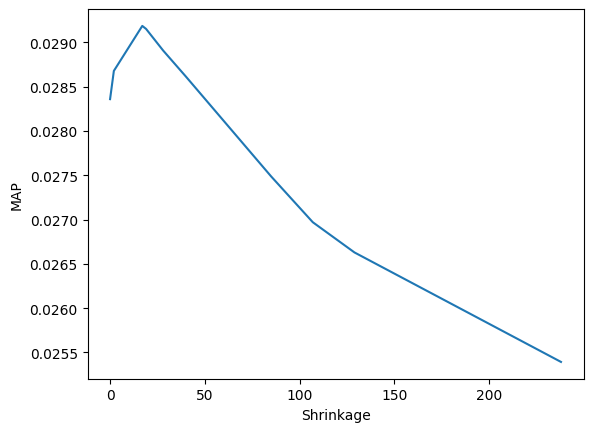

In [19]:
pyplot.plot(
    hyperparameter_search_rnd["shrink"].values, hyperparameter_search_rnd["MAP"].values
)
pyplot.ylabel("MAP")
pyplot.xlabel("Shrinkage")
pyplot.show()

#### The shrinkage value (i.e. support) has no impact. Combine a parameter search with the two to ensure maximum recommendation quality

## REMINDER: Be careful, overfitting!

#### While a thorough parameter tuning might result in significantly higher MAP on your validation split, it could have only marginally better or even worse MAP on the test set

# User-based Collaborative Filtering

#### We apply the cosine similarity again, but using the URM rows

In [20]:
user_id = 80
shrink = 10

numerator_vector = URM_train[user_id].dot(URM_train.T).toarray().ravel()

user_norms = np.sqrt(np.array(URM_train.T.power(2).sum(axis=0))).ravel()
denominator_vector = user_norms[user_id] * user_norms + shrink + 1e-6

similarity_vector = numerator_vector / denominator_vector

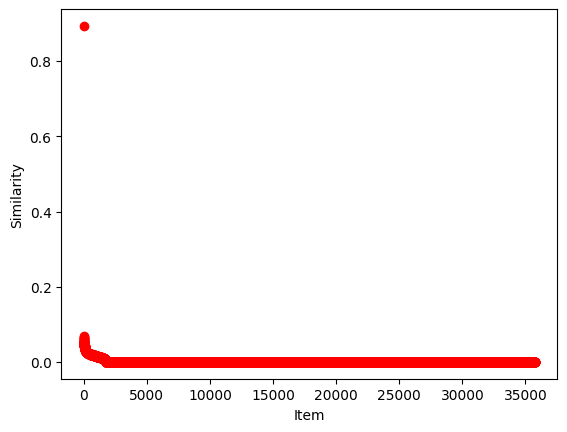

In [21]:
sorted_user_indices = np.argsort(-similarity_vector)

pyplot.plot(similarity_vector[sorted_user_indices], "ro")
pyplot.ylabel("Similarity")
pyplot.xlabel("Item")
pyplot.show()

### Let's compute the whole similarity and see the predictions for a certain user

In [22]:
from Recommenders.Similarity.Compute_Similarity_Python import Compute_Similarity_Python

similarity_object = Compute_Similarity_Python(
    URM_train.T, shrink=100, topK=50, normalize=True, similarity="cosine"
)

W_sparse = similarity_object.compute_similarity()

Similarity column 35736 (100.0%), 1622.63 column/sec. Elapsed time 22.02 sec


#### Note that in this case the prediction is computed in a different way compared to the Item based

In [23]:
user_id = 80

scores = W_sparse[user_id, :].dot(URM_train).toarray().ravel()

ranking = scores.argsort()[::-1]

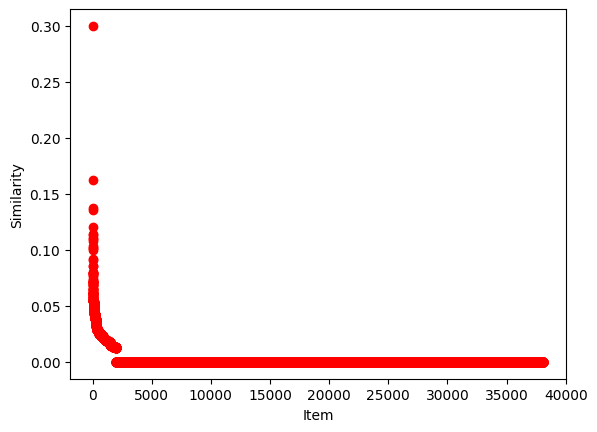

In [24]:
pyplot.plot(scores[ranking], "ro")
pyplot.ylabel("Similarity")
pyplot.xlabel("Item")
pyplot.show()

### Then compute the final recommendation list

In [25]:
ranking[0:10]

array([ 1243,  5110,   232,  3869,  5569,  5594, 10291,  5596,  6009,
        3081])

## Put all together in a class

In [26]:
class UserKNNCFRecommender(object):
    def __init__(self, URM):
        self.URM = URM

    def fit(self, topK=50, shrink=100, normalize=True, similarity="cosine"):
        similarity_object = Compute_Similarity_Python(
            self.URM.T,
            shrink=shrink,
            topK=topK,
            normalize=normalize,
            similarity=similarity,
        )

        self.W_sparse = similarity_object.compute_similarity()

    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product

        scores = self.W_sparse[user_id, :].dot(self.URM).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]

        return ranking[:at]

    def filter_seen(self, user_id, scores):
        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id + 1]

        user_profile = self.URM.indices[start_pos:end_pos]

        scores[user_profile] = -np.inf

        return scores

## Test our CF recommender:

In [27]:
recommender = UserKNNCFRecommender(URM_train)
recommender.fit(shrink=0.0, topK=50)

Similarity column 35736 (100.0%), 1662.26 column/sec. Elapsed time 21.50 sec


####  Let's compute recommendations for a fixed group of users

In [28]:
import time

n_users_to_test = 1000

start_time = time.time()

for user_id in range(n_users_to_test):
    recommender.recommend(user_id, at=5)

end_time = time.time()

print(
    "Reasonable implementation speed is {:.2f} usr/sec".format(
        n_users_to_test / (end_time - start_time)
    )
)

Reasonable implementation speed is 229.39 usr/sec


## Hyperparameter tuning

#### Once we have built our model we can play with its parameters
* Number of neighbors
* Shrinkage
* Similarity type

#### Number of neighbors

In [29]:
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender

hyperparameter_search_rnd = pd.DataFrame(columns=["k", "MAP"])
hyperparameter_search_rnd["k"] = loguniform.rvs(10, 1000, size=11).astype(int)
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="k")

for index in hyperparameter_search_rnd.index:
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=hyperparameter_search_rnd.loc[index, "k"])

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    hyperparameter_search_rnd.loc[index, "MAP"] = result_df.loc[10]["MAP"]

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 35736 (100.0%), 1675.20 column/sec. Elapsed time 21.33 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 11.48 sec. Users per second: 3074
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 35736 (100.0%), 1740.77 column/sec. Elapsed time 20.53 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 11.53 sec. Users per second: 3060
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 35736 (100.0%), 1685.24 column/sec. Elapsed time 21.21 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 12.90 sec. Users per second: 2736
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 35736 (100.0%), 1621.87 column/sec. Elapsed time 22.03 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 13.90 sec. Users per second: 2539
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 35736 (100.0%), 1647.74 column/sec. Elapsed 

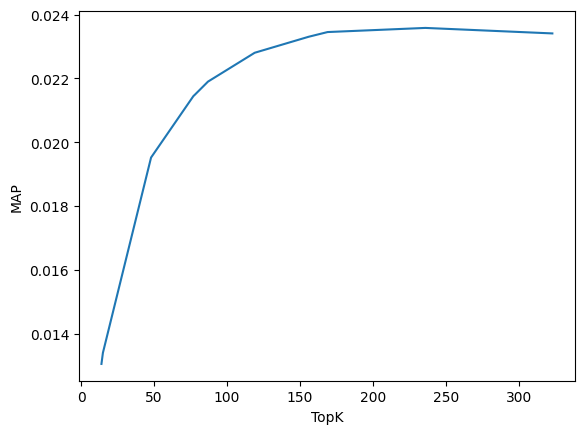

In [30]:
pyplot.plot(
    hyperparameter_search_rnd["k"].values, hyperparameter_search_rnd["MAP"].values
)
pyplot.ylabel("MAP")
pyplot.xlabel("TopK")
pyplot.show()

#### On this dataset the number of neighbors does not have a great impact on MAP. Higher values of TopK might work even better

#### Different datasets will behave in different ways.

### Shrinkage

In [31]:
best_k_value = hyperparameter_search_rnd.loc[
    hyperparameter_search_rnd["MAP"].astype(float).idxmax()
]
best_k_value

k           236
MAP    0.023582
Name: 4, dtype: object

In [32]:
hyperparameter_search_rnd = pd.DataFrame(columns=["k", "shrink", "MAP"])
hyperparameter_search_rnd["shrink"] = loguniform.rvs(0.1, 1000, size=11).astype(int)
hyperparameter_search_rnd = hyperparameter_search_rnd.sort_values(by="shrink")
hyperparameter_search_rnd["k"] = best_k_value["k"]

for index in hyperparameter_search_rnd.index:
    recommender = UserKNNCFRecommender(URM_train)
    recommender.fit(
        shrink=hyperparameter_search_rnd.loc[index, "shrink"],
        topK=hyperparameter_search_rnd.loc[index, "k"],
    )

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    hyperparameter_search_rnd.loc[index, "MAP"] = result_df.loc[10]["MAP"]

Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 35736 (100.0%), 1368.18 column/sec. Elapsed time 26.12 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 17.72 sec. Users per second: 1991
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 35736 (100.0%), 1474.26 column/sec. Elapsed time 24.24 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 17.85 sec. Users per second: 1977
Unable to load Cython Compute_Similarity, reverting to Python
Similarity column 35736 (100.0%), 1440.88 column/sec. Elapsed time 24.80 sec
EvaluatorHoldout: Processed 35281 (100.0%) in 17.71 sec. Users per second: 1992
Unable to load Cython Compute_Similarity, reverting to Python


KeyboardInterrupt: 

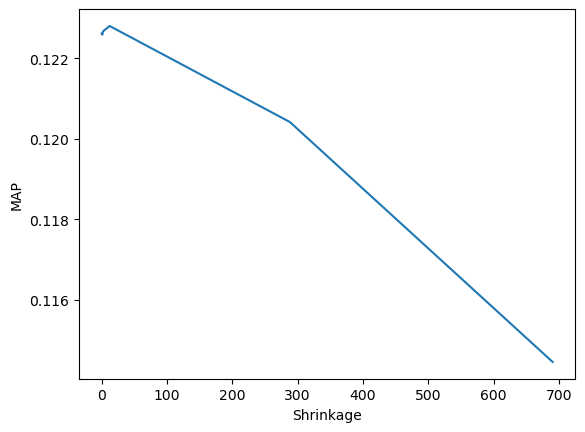

In [ ]:
pyplot.plot(
    hyperparameter_search_rnd["shrink"].values, hyperparameter_search_rnd["MAP"].values
)
pyplot.ylabel("MAP")
pyplot.xlabel("Shrinkage")
pyplot.show()

### Comparing different similarity heuristics

#### Let's see how different are the similarities 

In [ ]:
similarity_heuristic_list = ["cosine", "dice", "jaccard", "pearson"]
similarity_dict = {}

for similarity_heuristic in similarity_heuristic_list:
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(shrink=0.0, topK=100, similarity=similarity_heuristic)

    similarity_dict[similarity_heuristic] = recommender.W_sparse

ItemKNNCFRecommender: URM Detected 65 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 1247.75 column/sec. Elapsed time 8.56 sec
ItemKNNCFRecommender: URM Detected 65 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 1270.80 column/sec. Elapsed time 8.40 sec
ItemKNNCFRecommender: URM Detected 65 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 1259.76 column/sec. Elapsed time 8.48 sec
ItemKNNCFRecommender: URM Detected 65 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 1215.94 column/sec. Elapsed time 8.78 sec


#### Let's see what is the similarity distribution

In [ ]:
W_cosine = similarity_dict["cosine"]
W_cosine.tocoo()

coordinates_sorted = np.argsort(-W_cosine.data)

cosine_similarities_sorted = W_cosine.data[coordinates_sorted]
cosine_similarities_sorted

array([1.0000000e+00, 1.0000000e+00, 9.9999994e-01, ..., 1.1209262e-03,
       1.0284700e-03, 9.5932937e-04], dtype=float32)

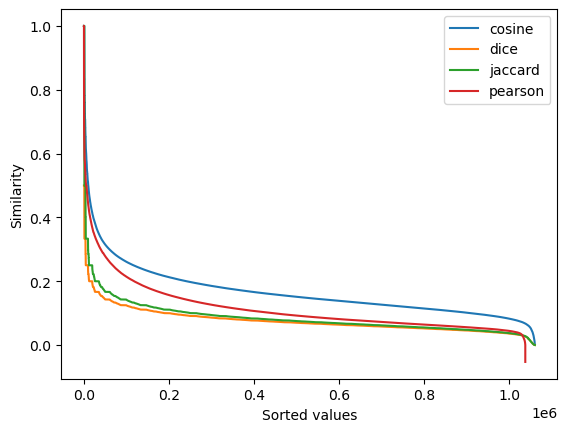

In [ ]:
for similarity_heuristic in similarity_heuristic_list:
    W_sparse = similarity_dict[similarity_heuristic]

    pyplot.plot(-np.sort(-W_sparse.data), label=similarity_heuristic)


pyplot.ylabel("Similarity")
pyplot.xlabel("Sorted values")
pyplot.legend()
pyplot.show()

In [ ]:
W_cosine = similarity_dict["cosine"]
W_cosine.nonzero()

(array([    0,     0,     0, ..., 10676, 10676, 10676], dtype=int32),
 array([   12,   310,   312, ...,  8828,  9016, 10419], dtype=int32))

In [ ]:
cosine_sorted_coordinates = np.argsort(-np.array(W_cosine[W_cosine.nonzero()]).ravel())
cosine_sorted_coordinates

array([1013235, 1013228, 1038191, ...,    1595,   56033,   39032],
      dtype=int64)

In [ ]:
W_sparse = similarity_dict["cosine"]
similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()
similarity_values[cosine_sorted_coordinates]

array([1.0000000e+00, 1.0000000e+00, 9.9999994e-01, ..., 1.1209262e-03,
       1.0284700e-03, 9.5932937e-04], dtype=float32)

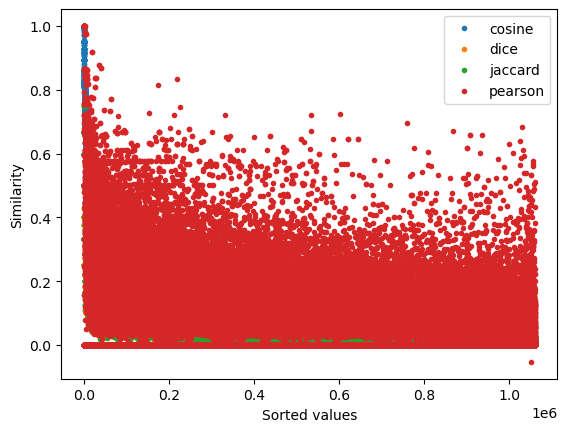

In [ ]:
for similarity_heuristic in similarity_heuristic_list:
    W_sparse = similarity_dict[similarity_heuristic]

    # Sort similarities according to cosine
    similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()

    pyplot.plot(
        similarity_values[cosine_sorted_coordinates],
        label=similarity_heuristic,
        marker=".",
        linestyle="",
    )


pyplot.ylabel("Similarity")
pyplot.xlabel("Sorted values")
pyplot.legend()
pyplot.show()

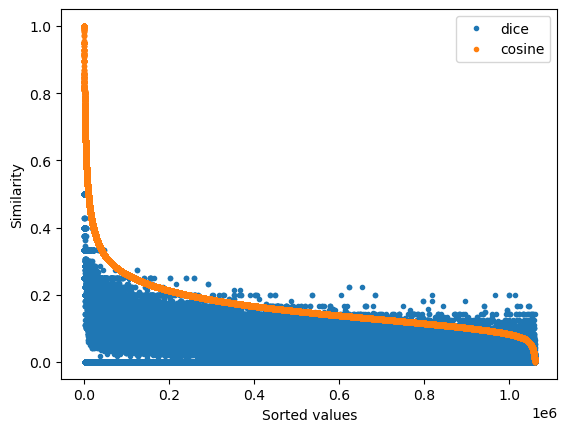

In [ ]:
for similarity_heuristic in ["dice", "cosine"]:
    W_sparse = similarity_dict[similarity_heuristic]

    # Sort similarities according to cosine
    similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()

    pyplot.plot(
        similarity_values[cosine_sorted_coordinates],
        label=similarity_heuristic,
        marker=".",
        linestyle="",
    )


pyplot.ylabel("Similarity")
pyplot.xlabel("Sorted values")
pyplot.legend()
pyplot.show()

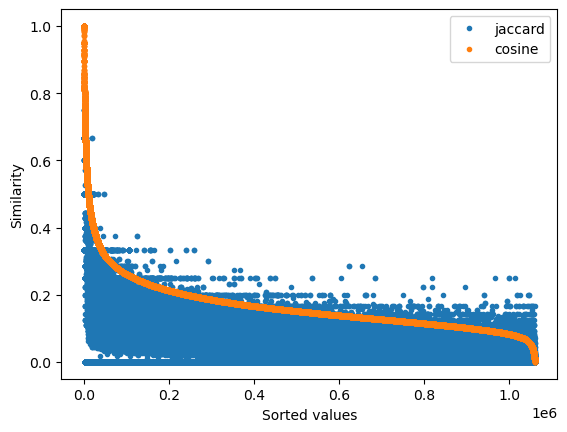

In [ ]:
for similarity_heuristic in ["jaccard", "cosine"]:
    W_sparse = similarity_dict[similarity_heuristic]

    # Sort similarities according to cosine
    similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()

    pyplot.plot(
        similarity_values[cosine_sorted_coordinates],
        label=similarity_heuristic,
        marker=".",
        linestyle="",
    )


pyplot.ylabel("Similarity")
pyplot.xlabel("Sorted values")
pyplot.legend()
pyplot.show()

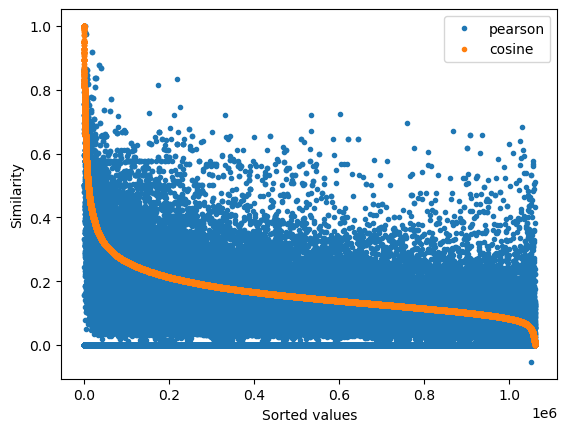

In [ ]:
for similarity_heuristic in ["pearson", "cosine"]:
    W_sparse = similarity_dict[similarity_heuristic]

    # Sort similarities according to cosine
    similarity_values = np.array(W_sparse[W_cosine.nonzero()]).ravel()

    pyplot.plot(
        similarity_values[cosine_sorted_coordinates],
        label=similarity_heuristic,
        marker=".",
        linestyle="",
    )


pyplot.ylabel("Similarity")
pyplot.xlabel("Sorted values")
pyplot.legend()
pyplot.show()

## Comparing CF and CBF item-based KNNs

In [ ]:
ICM_all = dataset.get_loaded_ICM_dict()["ICM_all"]
ICM_all

<10681x10126 sparse matrix of type '<class 'numpy.float64'>'
	with 128384 stored elements in Compressed Sparse Row format>

### Rewrite the content-based recommender

In [ ]:
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender


hyperparameter_search_rnd = pd.DataFrame(columns=["k", "shrink", "MAP_CF", "MAP_CBF"])
hyperparameter_search_rnd["k"] = loguniform.rvs(10, 1000, size=11).astype(int)
hyperparameter_search_rnd["shrink"] = loguniform.rvs(10, 1000, size=11).astype(int)
hyperparameter_search_rnd

,k,shrink,MAP_CF,MAP_CBF
0,25,345,NaN,NaN
1,28,126,NaN,NaN
2,54,69,NaN,NaN
3,34,24,NaN,NaN
4,93,451,NaN,NaN
5,112,423,NaN,NaN
6,27,52,NaN,NaN
7,638,929,NaN,NaN
8,20,52,NaN,NaN
9,20,726,NaN,NaN


In [ ]:
for index in hyperparameter_search_rnd.index:
    recommender = ItemKNNCFRecommender(URM_train)
    recommender.fit(
        shrink=hyperparameter_search_rnd.loc[index, "shrink"],
        topK=hyperparameter_search_rnd.loc[index, "k"],
    )

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    hyperparameter_search_rnd.loc[index, "MAP_CF"] = result_df.loc[10]["MAP"]

    recommender = ItemKNNCBFRecommender(URM_train, ICM_all)
    recommender.fit(
        shrink=hyperparameter_search_rnd.loc[index, "shrink"],
        topK=hyperparameter_search_rnd.loc[index, "k"],
    )

    result_df, _ = evaluator_validation.evaluateRecommender(recommender)

    hyperparameter_search_rnd.loc[index, "MAP_CBF"] = result_df.loc[10]["MAP"]

ItemKNNCFRecommender: URM Detected 65 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 1166.03 column/sec. Elapsed time 9.16 sec
EvaluatorHoldout: Processed 69649 (100.0%) in 44.29 sec. Users per second: 1573
ItemKNNCBFRecommender: URM Detected 65 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 6681.33 column/sec. Elapsed time 1.60 sec
EvaluatorHoldout: Processed 69649 (100.0%) in 48.18 sec. Users per second: 1446
ItemKNNCFRecommender: URM Detected 65 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 1187.36 column/sec. Elapsed time 9.00 sec
EvaluatorHoldout: Processed 69649 (100.0%) in 45.90 sec. Users per second: 1517
ItemKNNCBFRecommender: URM Detected 65 ( 0.6%) items with no interactions.
Similarity column 10681 (100.0%), 6524.78 column/sec. Elapsed time 1.64 sec
EvaluatorHoldout: Processed 69649 (100.0%) in 47.54 sec. Users per second: 1465
ItemKNNCFRecommender: URM Detected 65 ( 0.6%) items with no interactions.
Simi

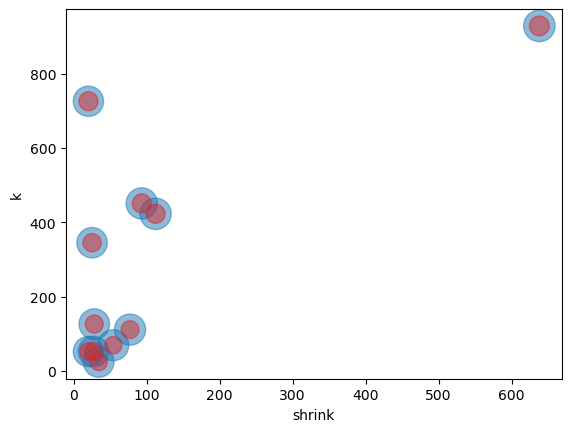

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(
    hyperparameter_search_rnd["k"].values,
    hyperparameter_search_rnd["shrink"].values,
    s=hyperparameter_search_rnd["MAP_CF"].values.astype(float) * 5000,
    c="tab:blue",
    label="tab:blue",
    alpha=0.5,
)
plt.scatter(
    hyperparameter_search_rnd["k"].values,
    hyperparameter_search_rnd["shrink"].values,
    s=hyperparameter_search_rnd["MAP_CBF"].values.astype(float) * 5000,
    c="tab:red",
    label="tab:red",
    alpha=0.5,
)
plt.xlabel("shrink")
plt.ylabel("k")
plt.show()

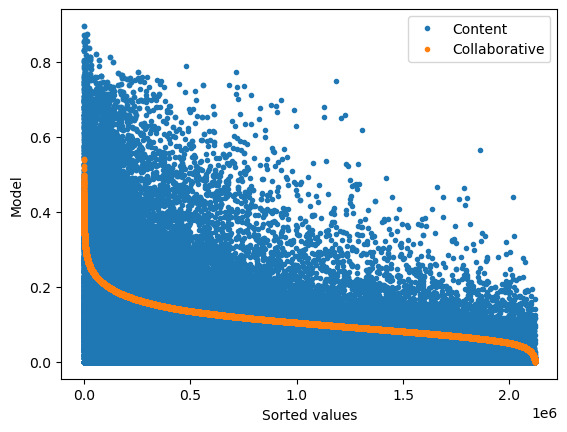

In [ ]:
W_collaborative = collaborative_recommender.W_sparse
W_content = content_recommender.W_sparse

# Sort similarities according to cosine
collaborative_similarity_values = np.array(
    W_collaborative[W_collaborative.nonzero()]
).ravel()
content_similarity_values = np.array(W_content[W_collaborative.nonzero()]).ravel()

sorted_args = np.argsort(-collaborative_similarity_values)

pyplot.plot(
    content_similarity_values[sorted_args], label="Content", marker=".", linestyle=""
)

pyplot.plot(
    collaborative_similarity_values[sorted_args],
    label="Collaborative",
    marker=".",
    linestyle="",
)

pyplot.ylabel("Model")
pyplot.xlabel("Sorted values")
pyplot.legend()
pyplot.show()

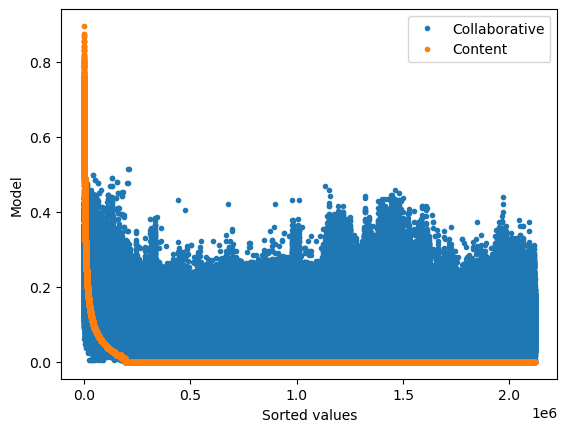

In [ ]:
sorted_args = np.argsort(-content_similarity_values)

pyplot.plot(
    collaborative_similarity_values[sorted_args],
    label="Collaborative",
    marker=".",
    linestyle="",
)

pyplot.plot(
    content_similarity_values[sorted_args], label="Content", marker=".", linestyle=""
)

pyplot.ylabel("Model")
pyplot.xlabel("Sorted values")
pyplot.legend()
pyplot.show()

## Collaborative is outperforming content-based by a large margin, as we could expect

### Let's try to see how the recommendations are distributed

In [ ]:
x_tick = np.arange(URM_all.shape[1])
counter_content = np.zeros(URM_all.shape[1])
counter_collaborative = np.zeros(URM_all.shape[1])

for user_id in range(URM_all.shape[0]):
    recs = collaborative_recommender.recommend(user_id)[:10]
    counter_collaborative[recs] += 1

    recs = content_recommender.recommend(user_id)[:10]
    counter_content[recs] += 1

    if user_id % 10000 == 0:
        print("Recommended to user {}/{}".format(user_id, URM_all.shape[0]))

Recommended to user 0/69878
Recommended to user 10000/69878
Recommended to user 20000/69878
Recommended to user 30000/69878
Recommended to user 40000/69878
Recommended to user 50000/69878
Recommended to user 60000/69878


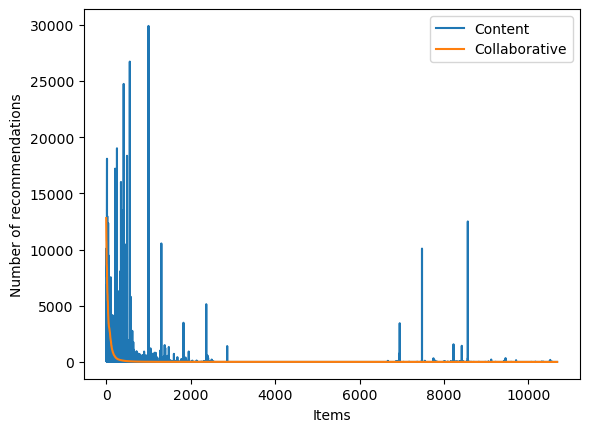

In [ ]:
sorted_items = np.argsort(-counter_collaborative)

pyplot.plot(x_tick, counter_content[sorted_items], label="Content")
pyplot.plot(x_tick, counter_collaborative[sorted_items], label="Collaborative")

pyplot.ylabel("Number of recommendations")
pyplot.xlabel("Items")
pyplot.legend()
pyplot.show()

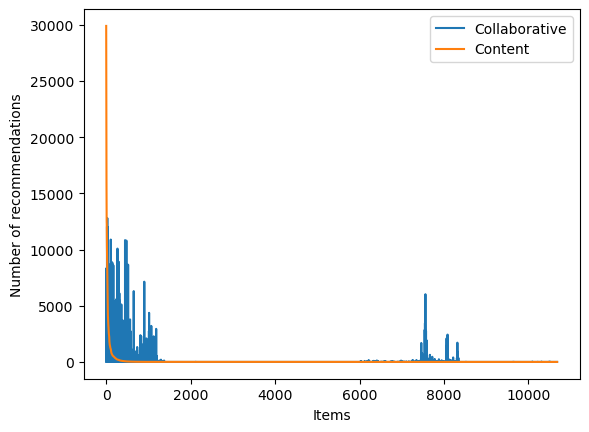

In [ ]:
sorted_items = np.argsort(-counter_content)

pyplot.plot(x_tick, counter_collaborative[sorted_items], label="Collaborative")
pyplot.plot(x_tick, counter_content[sorted_items], label="Content")

pyplot.ylabel("Number of recommendations")
pyplot.xlabel("Items")
pyplot.legend()
pyplot.show()

### Ideas on what you could do to improve your model recommendation quality. We will mostly not discuss them explicitly, but if you have questions on them please send us an email or use the challenge forum. For algorithms like matrix decompositions you can use the implementation provided in the libraries (scikit-learn mostly), for other types of algorithms please check with us directly before using them.

* Feature weighting applies not only to item features or user features. The items a user interacted with can themselves be considered as user features and vice versa. Feature weighting can be applied to items and users even in a collaborative model.


* Feature selection, a specific type of feature weigthing (weights are only 0 or 1) is too useful. You may remove some items or users because they add noise. Remember, the items you remove will likely never be recommended and the users you remove will become cold users, you may need to add an ad-hoc strategy to recommend to them (for example, top popular).


* There are a lot of techniques to perform feature weigthing and selection, we saw rapidly IDF and BM25, but many other are possible, for example removing features that have low variance or features that have a low correlation with the desired model output (used in classification, more difficult in RecSys). See as initial reference: https://scikit-learn.org/stable/modules/feature_selection.html.


* Sometimes the features can be represented in a different space, for example by using Principal component analysis, Independent Component Analysis, Non-Negative Matrix Factorization or Canonical Correlation Analysis... Those will all allow you to represent the ICM (or URM in fact) as a different matrix which contains approximately the same information but represented in a different way. Usually, you have the same number of items but each item has a vector of length much lower than the number of original features, these vectors are called embeddings and their length is the number of "components" or "latent dimensions". The less you have, the more compressed the data is. Not all decompositions are interchangeable. Remember that KNNs work by looking for "common features", if you compress the data a little you may improve your model because you remove noise, but if you compress too much you end up with a set of almost completely independend features and your KNN model may not work. See: https://scikit-learn.org/stable/modules/classes.html#module-sklearn.decomposition


* The user-item interaction value is not set in stone, you can weight that number according to some heuristics, for example you can weight less interactions of very popular items or users with huge profiles, this will impact how the item-item or user-user similarities are computed.  For example: interaction value * log(popularity) or sqrt(popularity) or other ways, it is a heuristic so its success depends on the data and you may need to try a few


* Implement new similarities, there is a number of variants of the heuristics we have shown you or you can design your own combining them and adding new hyperparameters to weight them. See for example: "Vito Walter Anelli, Tommaso Di Noia, Eugenio Di Sciascio, Azzurra Ragone, and Joseph Trotta. 2019. The importance of being dissimilar in recommendation. In Proceedings of the 34th ACM/SIGAPP Symposium on Applied Computing (SAC '19)": https://dl.acm.org/doi/pdf/10.1145/3297280.3297360 


* Optimization of hyperparameters is very important in any prediction/classification/recommendation task. Sometimes spending a few extra hours optimizing is more efficient than spending a few days in searching for new ideas or models. Combine the two for the best outcome!


* Keep it simple. The literature is full of complex or over-complex models that promise in theory of being able to learn everything but, in practice, they may be very difficult to implement, train and optimize. Prefer simple models to very complex ones, you may spend a lot of time to get them to run and train only to discover that it takes 15 hours for them to complete their training on a single hyperparameter set.  "Maurizio Ferrari Dacrema, Paolo Cremonesi, and Dietmar Jannach. 2019. Are we really making much progress? A worrying analysis of recent neural recommendation approaches. In Proceedings of the 13th ACM Conference on Recommender Systems (RecSys '19).": https://doi.org/10.1145/3298689.3347058 https://arxiv.org/abs/1907.06902